# Disaster Declaration
This analysis aims to identify what factors result in an emergency declaration that lasts more than 1 month (30 days)

## The data
This dataset was downloaded from Kaggle

# Context
The president can declare an emergency for any occasion or instance when the President determines federal assistance is needed. Emergency declarations supplement State and local or Indian tribal government efforts in providing emergency services, such as the protection of lives, property, public health, and safety, or to lessen or avert the threat of a catastrophe in any part of the United States. The total amount of assistance provided for in a single emergency may not exceed $5 million.

The president can declare a major disaster for any natural event, including any hurricane, tornado, storm, high water, wind-driven water, tidal wave, tsunami, earthquake, volcanic eruption, landslide, mudslide, snowstorm, or drought, or, regardless of cause, fire, flood, or explosion, that the President determines has caused damage of such severity that it is beyond the combined capabilities of state and local governments to respond. A major disaster declaration provides a wide range of federal assistance programs for individuals and public infrastructure, including funds for both emergency and permanent work.

# Content
This dataset includes a record for every federal emergency or disaster declared by the President of the United States since 1953.

# Acknowledgements
The disaster database was published by the Federal Emergency Management Agency with data from the National Emergency Management Information System.

# 1. Data Cleaning

In [2]:
#load in packages
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('database.csv')

In [4]:
df.head()

Declaration Number Declaration Type Declaration Date State County  \
0               DR-1         Disaster       05/02/1953    GA    NaN   
1               DR-2         Disaster       05/15/1953    TX    NaN   
2               DR-3         Disaster       05/29/1953    LA    NaN   
3               DR-4         Disaster       06/02/1953    MI    NaN   
4               DR-5         Disaster       06/06/1953    MT    NaN   

  Disaster Type              Disaster Title  Start Date    End Date  \
0       Tornado                     Tornado  05/02/1953  05/02/1953   
1       Tornado  Tornado and Heavy Rainfall  05/15/1953  05/15/1953   
2         Flood                       Flood  05/29/1953  05/29/1953   
3       Tornado                     Tornado  06/02/1953  06/02/1953   
4         Flood                      Floods  06/06/1953  06/06/1953   

   Close Date Individual Assistance Program Individuals & Households Program  \
0  06/01/1954                           Yes                               No   
1  01/01/1958                           Yes                               No   
2  02/01/1960                           Yes                               No   
3  02/01/1956                           Yes                               No   
4  12/01/1955                           Yes                               No   

  Public Assistance Program Hazard Mitigation Program  
0                       Yes                       Yes  
1                       Yes                       Yes  
2                       Yes                       Yes  
3                       Yes                       Yes  
4                       Yes                       Yes

In [5]:
#Remove spaces and special characters from column names
df.columns = df.columns.str.replace(' ', '')
df.columns = df.columns.str.replace('&', '')
df.head()

DeclarationNumber DeclarationType DeclarationDate State County DisasterType  \
0              DR-1        Disaster      05/02/1953    GA    NaN      Tornado   
1              DR-2        Disaster      05/15/1953    TX    NaN      Tornado   
2              DR-3        Disaster      05/29/1953    LA    NaN        Flood   
3              DR-4        Disaster      06/02/1953    MI    NaN      Tornado   
4              DR-5        Disaster      06/06/1953    MT    NaN        Flood   

                DisasterTitle   StartDate     EndDate   CloseDate  \
0                     Tornado  05/02/1953  05/02/1953  06/01/1954   
1  Tornado and Heavy Rainfall  05/15/1953  05/15/1953  01/01/1958   
2                       Flood  05/29/1953  05/29/1953  02/01/1960   
3                     Tornado  06/02/1953  06/02/1953  02/01/1956   
4                      Floods  06/06/1953  06/06/1953  12/01/1955   

  IndividualAssistanceProgram IndividualsHouseholdsProgram  \
0                         Yes                           No   
1                         Yes                           No   
2                         Yes                           No   
3                         Yes                           No   
4                         Yes                           No   

  PublicAssistanceProgram HazardMitigationProgram  
0                     Yes                     Yes  
1                     Yes                     Yes  
2                     Yes                     Yes  
3                     Yes                     Yes  
4                     Yes                     Yes

In [6]:
#look at types of disasters
df.DeclarationType.value_counts()

Disaster     33630
Emergency    11520
Fire          1035
Name: DeclarationType, dtype: int64

In [7]:
#check for null values
df.isnull().values.any()

True

In [8]:
print(100 * df.isnull().sum()/len(df))

DeclarationNumber                0.000000
DeclarationType                  0.000000
DeclarationDate                  0.000000
State                            0.000000
County                           0.426545
DisasterType                     0.000000
DisasterTitle                    0.000000
StartDate                        0.000000
EndDate                          0.740500
CloseDate                       23.763127
IndividualAssistanceProgram      0.000000
IndividualsHouseholdsProgram     0.000000
PublicAssistanceProgram          0.000000
HazardMitigationProgram          0.000000
dtype: float64


In [9]:
#since we need to know the length of the disaster/emergency declaration, let's remove missing close dates
df = df.dropna(subset=['CloseDate'])

In [10]:
print(100 * df.isnull().sum()/len(df))
df.shape

DeclarationNumber               0.000000
DeclarationType                 0.000000
DeclarationDate                 0.000000
State                           0.000000
County                          0.559500
DisasterType                    0.000000
DisasterTitle                   0.000000
StartDate                       0.000000
EndDate                         0.959955
CloseDate                       0.000000
IndividualAssistanceProgram     0.000000
IndividualsHouseholdsProgram    0.000000
PublicAssistanceProgram         0.000000
HazardMitigationProgram         0.000000
dtype: float64


(35210, 14)

In [11]:
#Let's remove the county feature and just look at differences by state, since the number of unique counties will be 
#too many and it has missing values. 
df = df.drop(['County'], 1)

In [12]:
#convert dates from objects to date time
from datetime import datetime
df.StartDate = pd.to_datetime(df.StartDate)
df.EndDate = pd.to_datetime(df.EndDate)
df.CloseDate = pd.to_datetime(df.CloseDate)
df.DeclarationDate = pd.to_datetime(df.DeclarationDate)

#create column that calculates the length of each declaration (it looks like the end date is the end date 
#for the disaster itself, and the close date is the end date for the declaration, 
#so here we'll use the start date and close date)
df['Length'] = df['CloseDate'] - df['DeclarationDate']

In [13]:
df.Length.describe()

count                        35210
mean     2515 days 06:28:34.013064
std      1478 days 20:28:46.839660
min                0 days 00:00:00
25%             1252 days 00:00:00
50%             2374 days 00:00:00
75%             3451 days 00:00:00
max            12107 days 00:00:00
Name: Length, dtype: object

In [14]:
#That max is way bigger than the 75% quartile, so lets remove it, but first,
#I'm pretty curious what happened for a delcaration that long
is_12107 =  df['Length']=='12107 days'
longest_dec = df[is_12107]
print(longest_dec.head())

     DeclarationNumber DeclarationType DeclarationDate State DisasterType  \
6696           EM-3066       Emergency      1978-08-07    NY     Chemical   

                    DisasterTitle  StartDate    EndDate  CloseDate  \
6696  Chemical Waste (Love Canal) 1978-08-07 1978-08-07 2011-09-30   

     IndividualAssistanceProgram IndividualsHouseholdsProgram  \
6696                          No                           No   

     PublicAssistanceProgram HazardMitigationProgram     Length  
6696                     Yes                     Yes 12107 days  


In [15]:
#drop the outlier
df = df.drop(df.Length.idxmax())
df.Length.describe()
df.dtypes

DeclarationNumber                        object
DeclarationType                          object
DeclarationDate                  datetime64[ns]
State                                    object
DisasterType                             object
DisasterTitle                            object
StartDate                        datetime64[ns]
EndDate                          datetime64[ns]
CloseDate                        datetime64[ns]
IndividualAssistanceProgram              object
IndividualsHouseholdsProgram             object
PublicAssistanceProgram                  object
HazardMitigationProgram                  object
Length                          timedelta64[ns]
dtype: object

In [16]:
import datetime as dt
#convert length to integers
df.Length = df.Length.dt.days
df.dtypes

DeclarationNumber                       object
DeclarationType                         object
DeclarationDate                 datetime64[ns]
State                                   object
DisasterType                            object
DisasterTitle                           object
StartDate                       datetime64[ns]
EndDate                         datetime64[ns]
CloseDate                       datetime64[ns]
IndividualAssistanceProgram             object
IndividualsHouseholdsProgram            object
PublicAssistanceProgram                 object
HazardMitigationProgram                 object
Length                                   int64
dtype: object

In [17]:
#look at difference between disaster type and disaster title to decide which one to use
df.DisasterType.value_counts()
df.DisasterType.nunique()

19

In [18]:
df.DisasterTitle.value_counts()

Severe Storms and Flooding                                                 5634
Hurricane Katrina Evacuation                                               2443
Severe Storms, Tornadoes, and Flooding                                     2357
Severe Winter Storm                                                        1406
Drought                                                                    1014
Flooding                                                                    936
Severe Winter Storms                                                        749
Snow                                                                        602
Heavy Rains and Flooding                                                    595
Severe Storms and Tornadoes                                                 527
Hurricane Sandy                                                             399
Wildfires                                                                   391
Severe Winter Ice Storm                 

# 2. Data Exploration

## 2.1 Evaluate Declaration Type Data

In [19]:
#A look at Declaration type
import seaborn as sns
sns.set(color_codes=True)
sums = df.DeclarationType.value_counts()
plt.pie(sums, labels=sums.index)
plt.title('Declaration by Type')

Text(0.5, 1.0, 'Declaration by Type')

Text(0.5, 1.0, 'Number of Declarations Over Time')

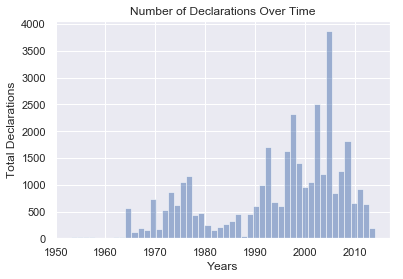

In [20]:
#Declarations over time

#convert declaration date to integer
df.DeclarationDate = df.DeclarationDate.dt.year

plt.hist(df.DeclarationDate, alpha = 0.5, bins=50)
plt.xlabel('Years')
plt.ylabel('Total Declarations')
plt.title('Number of Declarations Over Time')

In [24]:
fig, (axis1,axis2) = plt.subplots(2,1,figsize=(25,10))

axis1.set_title('Disasters by Type')
axis2.set_title('Disaster by State')
plt.ylabel("Total Declarations")
sns.countplot(x='DisasterType',ax=axis1,data=df, order=df['DisasterType'].value_counts().index)
sns.countplot(x='State',ax=axis2,data=df, order=df['State'].value_counts().index)


## 2.1 Evaluate Length data

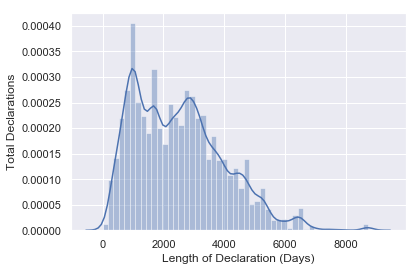

In [25]:
import seaborn as sns
sns.set(color_codes=True)

#look at distribution of length data
fig = sns.distplot(df.Length)
fig.set(xlabel='Length of Declaration (Days)', ylabel='Total Declarations')
plt.show()

In [26]:
#Evaluate length for disasters vs. emergencies
to_plot = df.Length[df['DeclarationType'] == 'Emergency']
to_plot2 = df.Length[df['DeclarationType'] == 'Disaster']

fig2 = sns.distplot(to_plot, label='Emergency')
fig2 = sns.distplot(to_plot2, label = "Disaster")

fig2.set(xlabel='Length of Declaration (Days)', ylabel='Total Declarations')
#plt.show()
#plt.hist(to_plot, alpha = 0.5, label = "Emergency", density = True)
#plt.hist(to_plot2, alpha = 0.5, label = "Disaster", density = True)
plt.legend(loc = 'upper right')
#plt.xlabel('Length of Declaration (Days)')
#plt.ylabel('Total Declarations')
#plt.show

Text(0, 0.5, 'Length of Declaration (Days)')

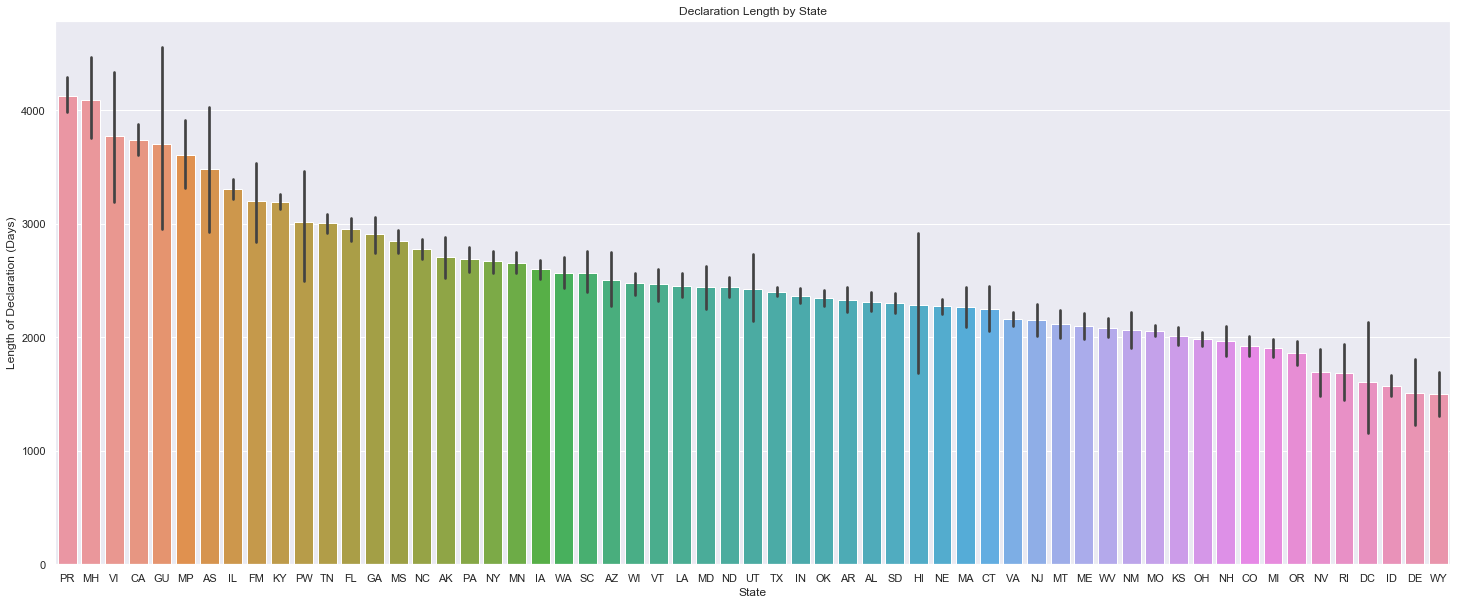

In [27]:
plt.figure(figsize=(25,10))

plt.title('Declaration Length by State')


result = df.groupby(["State"])['Length'].aggregate(np.mean).reset_index().sort_values('Length', ascending = False)
sns.barplot(x='State', y = 'Length', data=df, order = result['State'])
plt.ylabel("Length of Declaration (Days)")

In [28]:
#A look at Assistance program declarations
import seaborn as sns
sns.set(color_codes=True)
sums = df.IndividualAssistanceProgram.value_counts()
sums2 = df.IndividualsHouseholdsProgram.value_counts()
sums3 = df.PublicAssistanceProgram.value_counts()
sums4 = df.HazardMitigationProgram.value_counts()
ax1 = plt.subplot2grid((2,2),(0,0))
plt.pie(sums, labels=sums.index)
plt.title('Individual Assistance Program')
ax1 = plt.subplot2grid((2,2), (0, 1))
plt.pie(sums2, labels=sums.index)
plt.title('Individual Households Program')
ax1 = plt.subplot2grid((2,2), (1, 0))
plt.pie(sums3, labels=sums.index)
plt.title('Public Assistance Program')
ax1 = plt.subplot2grid((2,2), (1, 1))
plt.pie(sums4, labels=sums.index)
plt.title('Hazard Mitigation Program')

#IndividualsHouseholdsProgram	PublicAssistanceProgram	HazardMitigationProgram


Text(0.5, 1.0, 'Hazard Mitigation Program')

# 3. Start Building Our Model

In [29]:
#Start pairing down our dataframe for the model
df2 = df.drop(['DisasterTitle', 'StartDate', 'EndDate', 'CloseDate', 'DeclarationNumber'], 1)
df2.head()

DeclarationType  DeclarationDate State DisasterType  \
0        Disaster             1953    GA      Tornado   
1        Disaster             1953    TX      Tornado   
2        Disaster             1953    LA        Flood   
3        Disaster             1953    MI      Tornado   
4        Disaster             1953    MT        Flood   

  IndividualAssistanceProgram IndividualsHouseholdsProgram  \
0                         Yes                           No   
1                         Yes                           No   
2                         Yes                           No   
3                         Yes                           No   
4                         Yes                           No   

  PublicAssistanceProgram HazardMitigationProgram  Length  
0                     Yes                     Yes     395  
1                     Yes                     Yes    1692  
2                     Yes                     Yes    2439  
3                     Yes                     Yes     974  
4                     Yes                     Yes     908

In [30]:
#create x and y variables
X = df2.drop(['Length'],1)
y = df2.Length

#convert categorical variables to numeric
X = pd.get_dummies(X)                                

In [31]:
from sklearn.model_selection import train_test_split, cross_val_score
#get training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1,1)

## 3.1 Logistic Regression

In [32]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
lgr = linear_model.LogisticRegression()
lgrfit = lgr.fit(X_train, y_train.ravel())
print('R²:')
print(lgr.score(X_train, y_train.ravel()))

c:\users\kgrosse\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\kgrosse\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


R²:
0.5305526251724417


In [33]:
#check predictive power
print(lgr.score(X_test, y_test))

0.49597652182145224


## 3.2 Lasso Regression

In [34]:
from sklearn import preprocessing
lass = linear_model.Lasso(alpha=.35)
lassfit = lass.fit(X_train, y_train)
print('R²:')
print(lass.score(X_train, y_train))

R²:
0.5333529766537732


In [35]:
#check predictive power
print(lass.score(X_test, y_test))

0.5355458135439394


## 3.3 Ridge Regression

In [36]:
ridgeregr = linear_model.Ridge(alpha=10, fit_intercept=False) 
ridgeregr.fit(X_train, y_train)
print('R²:')
print(ridgeregr.score(X_train, y_train))

R²:
0.4556817746829711


In [37]:
#check predictive power
print(ridgeregr.score(X_test, y_test))

0.4613480370651273


looks like Lasso Regression is the most accurate model here, but it's still not great. Let's try ensemble modeling

## 3.4 Random Forest

In [38]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestRegressor(n_estimators = 100)
score = cross_val_score(rfc, X_train, y_train.ravel())
print ('Mean cross validation score for train is: ' + str(np.mean(score)))

c:\users\kgrosse\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Mean cross validation score for train is: 0.9749884063285869


97% accuracy is great! But let's check another ensemble model, gradient boosting

## 3.5 Gradient Boosting

In [39]:
#params = {'n_estimators': 500,
       #'max_depth': 3,
        # 'loss': 'deviance'}

clf = ensemble.GradientBoostingRegressor()
model = clf.fit(X_train, y_train.ravel())
score = cross_val_score(model, X_train, y_train.ravel(), cv=10)
print ('Mean cross validation score for train is: ' + str(np.mean(score)))

Mean cross validation score for train is: 0.7353186592309766


Looks like Random Forest is going to be our model of choice.

# 4.0 Model Tuning

In [40]:
#First let's messaround with the number of estimators and the cross validation iteration value (cv) to see what gets us the best accuracy

rfc_f = ensemble.RandomForestRegressor(n_estimators = 100)
model = rfc_f.fit(X_train, y_train.ravel())
score = cross_val_score(model, X_train, y_train.ravel(), cv = 15)
print ('Mean cross validation score for train is: ' + str(np.mean(score)))

Mean cross validation score for train is: 0.979746138738769


Looks like the highest accuracy and easiest run time comes from a model with 100 estimators and a cv of 15

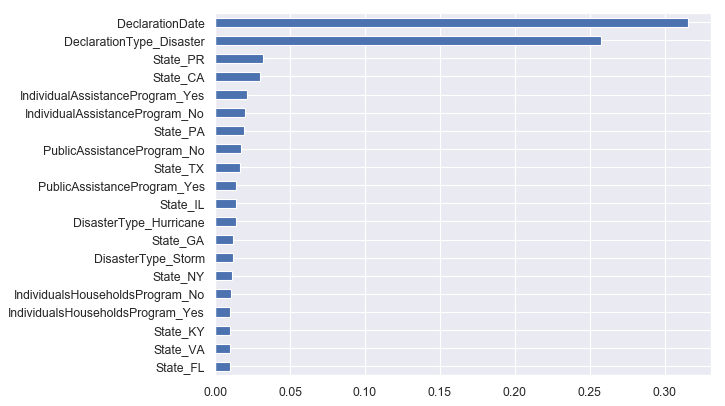

In [41]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
feat_importances = pd.Series(rfc_f.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.gca().invert_yaxis()

It looks like the year of the declaration is the main driver of how long the declaration lasts. While the State of California is the third most important feature, there are also a lot of states that aren't on this list. Let's remove the states from the model and run it independent of state, to figure out the main drivers of how long a declaration lasts

In [42]:
X2 = df2.drop(['Length', 'State'],1)
y2 = df2.Length

#convert categorical variables to numeric
X2 = pd.get_dummies(X2)   

#get new training and testing data
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.3, random_state=42)
y_train2 = y_train2.values.reshape(-1, 1)
y_test2 = y_test2.values.reshape(-1,1)

In [44]:
rfc_s = ensemble.RandomForestRegressor(n_estimators = 100)
model2 = rfc_s.fit(X_train2, y_train2.ravel())
score = cross_val_score(model2, X_train2, y_train2.ravel(), cv = 15)
print ('Mean cross validation score for train is: ' + str(np.mean(score)))

Mean cross validation score for train is: 0.6990197896625039


Looks like removing the State variable decreased our accuracy, so let's keep it in the model, but let's view the importances without it first

In [45]:
feat_importances = pd.Series(model2.feature_importances_, index=X2.columns)
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
feat_importances.nlargest(20).plot(kind='barh')
plt.gca().invert_yaxis()


This isn't what I want, I want the importance of each feature, not each dummy feature. Let's try rerunning the regression without using one hot encoding, and using label encoder instead.

In [46]:
from sklearn.preprocessing import LabelEncoder
X3 = df2.drop(['Length'],1)
y3 = df2.Length


# List of categorical features
cat_col = ['DeclarationType',
          'State', 
          'DisasterType',
          'IndividualAssistanceProgram',
          'IndividualsHouseholdsProgram',
          'PublicAssistanceProgram',
          'HazardMitigationProgram']

for col in cat_col:
    le = LabelEncoder()
    X3[col] = le.fit_transform(X3[col])

In [47]:
X3.head()

DeclarationType  DeclarationDate  State  DisasterType  \
0                0             1953     12            14   
1                0             1953     50            14   
2                0             1953     21             5   
3                0             1953     26            14   
4                0             1953     31             5   

   IndividualAssistanceProgram  IndividualsHouseholdsProgram  \
0                            1                             0   
1                            1                             0   
2                            1                             0   
3                            1                             0   
4                            1                             0   

   PublicAssistanceProgram  HazardMitigationProgram  
0                        1                        1  
1                        1                        1  
2                        1                        1  
3                        1                        1  
4                        1                        1

In [48]:
#get training and testing data
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.3, random_state=42)
y3_train = y3_train.values.reshape(-1, 1)
y3_test = y3_test.values.reshape(-1,1)

In [49]:
rfc_le = ensemble.RandomForestRegressor(n_estimators = 100)
model3 = rfc_le.fit(X3_train, y3_train.ravel())
score = cross_val_score(model3, X3_train, y3_train.ravel(), cv = 15)
print ('Mean cross validation score for train is: ' + str(np.mean(score)))

Mean cross validation score for train is: 0.9784317397012395


Changing the feature encoding method keeps the model at a similar accuracy

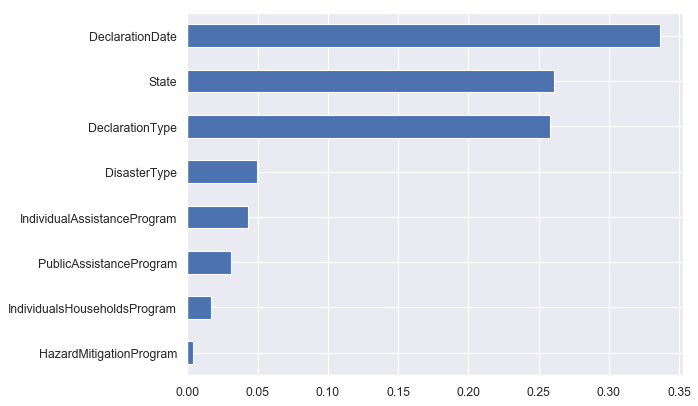

In [50]:
feat_importances = pd.Series(model3.feature_importances_, index=X3.columns)
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
feat_importances.nlargest(20).plot(kind='barh')
plt.gca().invert_yaxis()

That looks much better. Let's drop all the assistance program variables, since they have the lowest importances, and see if our model improves

In [51]:
X4 = X3.drop(['PublicAssistanceProgram', 'IndividualAssistanceProgram', 'HazardMitigationProgram', 'IndividualsHouseholdsProgram'], 1)
X4_train = X3_train.drop(['PublicAssistanceProgram', 'IndividualAssistanceProgram', 'HazardMitigationProgram', 'IndividualsHouseholdsProgram'], 1)
X4_test = X3_test.drop(['PublicAssistanceProgram', 'IndividualAssistanceProgram', 'HazardMitigationProgram', 'IndividualsHouseholdsProgram'], 1)

In [52]:
rfc_le2 = ensemble.RandomForestRegressor(n_estimators = 100)
model4 = rfc_le2.fit(X4_train, y3_train.ravel())
score = cross_val_score(model4, X4_train, y3_train.ravel(), cv = 15)
print ('Mean cross validation score for train is: ' + str(np.mean(score)))

Mean cross validation score for train is: 0.972317228874718


This has relatively the same accuracy as the other model. Let's keep them removed from the model in order to simplify it.

In [53]:
feat_importances = pd.Series(model4.feature_importances_, index=X4.columns)
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
feat_importances.nlargest(20).plot(kind='barh')
plt.gca().invert_yaxis()

In [54]:
#use test data to check for overfitting
rfc_le = ensemble.RandomForestRegressor(n_estimators = 100)
model4 = rfc_le.fit(X4_test, y3_test.ravel())
score = cross_val_score(model4, X4_test, y3_test.ravel(), cv = 15)
print ('Mean cross validation score for train is: ' + str(np.mean(score)))

Mean cross validation score for train is: 0.957091085880713


Because the test data has such a close accuracy score to the training data, we can determine that the model is not overfitting.